In [144]:
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
df = pd.read_excel("data/weather.xlsx")

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65529 entries, 0 to 65528
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Местное время в Липецке (аэропорт)  65529 non-null  object 
 1   T                                   65517 non-null  float64
 2   P0                                  65517 non-null  float64
 3   P                                   65529 non-null  float64
 4   U                                   65517 non-null  float64
 5   DD                                  65529 non-null  object 
 6   Ff                                  65529 non-null  int64  
 7   ff10                                750 non-null    float64
 8   WW                                  10863 non-null  object 
 9   W'W'                                121 non-null    object 
 10  c                                   59804 non-null  object 
 11  VV                                  65529

In [132]:
df = df.drop(["P0", "P", "U", "DD", "Ff", "ff10", "WW", "W'W'", "c", "VV", "Td"], axis=1)

In [133]:
df.head()

,Местное время в Липецке (аэропорт),T
0,01.12.2025 23:30,0.0
1,01.12.2025 23:00,0.0
2,01.12.2025 22:30,0.0
3,01.12.2025 22:00,0.0
4,01.12.2025 21:30,0.0


In [134]:
time_col = "Местное время в Липецке (аэропорт)"

In [135]:
df[time_col] = pd.to_datetime(df[time_col], format="%d.%m.%Y %H:%M")

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65529 entries, 0 to 65528
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Местное время в Липецке (аэропорт)  65529 non-null  datetime64[ns]
 1   T                                   65517 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [137]:
df = df.dropna()

In [138]:
df['date'] = df[time_col].dt.date

In [139]:
df

,Местное время в Липецке (аэропорт),T,date
0,2025-12-01 23:30:00,0.0,2025-12-01
1,2025-12-01 23:00:00,0.0,2025-12-01
2,2025-12-01 22:30:00,0.0,2025-12-01
3,2025-12-01 22:00:00,0.0,2025-12-01
4,2025-12-01 21:30:00,0.0,2025-12-01
...,...,...,...
65524,2021-12-18 09:30:00,-1.0,2021-12-18
65525,2021-12-18 09:00:00,-1.0,2021-12-18
65526,2021-12-18 08:30:00,-1.0,2021-12-18
65527,2021-12-18 08:00:00,-1.0,2021-12-18


In [140]:
min_temp = df.groupby('date')["T"]

In [141]:
series = min_temp.min().reset_index()

In [142]:
series["T"]

0       -2.0
1       -3.0
2      -10.0
3      -16.0
4      -21.0
        ... 
1439    -2.0
1440     1.0
1441     0.0
1442     0.0
1443     0.0
Name: T, Length: 1444, dtype: float64

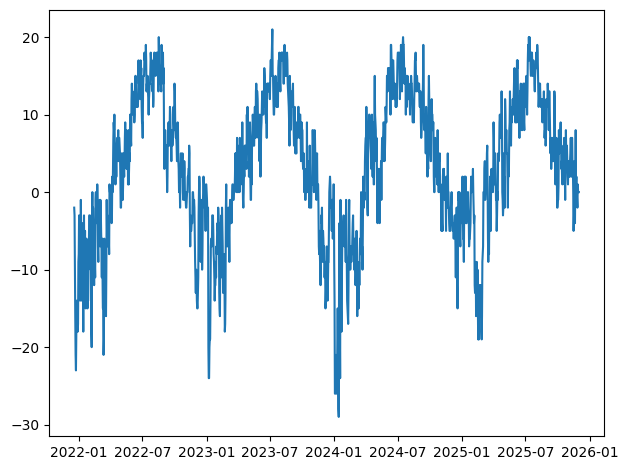

In [146]:
plt.plot(series["date"], series["T"])
plt.tight_layout()

In [162]:
def snaive_forecast(train_data, test_periods, index, seasonality=365):
    snaive_predictions = []
    
    for i in range(test_periods):
        if i < len(train_data) - seasonality:
            snaive_predictions.append(train_data.iloc[-seasonality + i])
        else:
            # Если недостаточно истории, используем последнее доступное (в тот же день, но, возможно, на год или несколько раньше)
            snaive_predictions.append(train_data.iloc[-seasonality + (i % seasonality)])
    
    return pd.Series(snaive_predictions, index=index)

In [161]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters (тройное экспоненциальное сглаживание)
def holt_winters_forecast(train_data, test_periods, index, seasonal_periods=365):
    try:
        # Пробуем модель с сезонностью
        model = ExponentialSmoothing(
            train_data,
            seasonal_periods=seasonal_periods,
            trend='add',
            seasonal='add',
            initialization_method='estimated'
        )
        model_fit = model.fit()
        forecast = model_fit.forecast(test_periods)
        return pd.Series(forecast, index=index)
    except:
        # Иначе пробуем без сезонности
        model = ExponentialSmoothing(
            train_data,
            trend='add',
            seasonal=None,
            initialization_method='estimated'
        )
        model_fit = model.fit()
        forecast = model_fit.forecast(test_periods)
        return pd.Series(forecast, index=index)

In [172]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


# Экспоненциальное сглаживание
def ses_forecast(train_data, test_periods, index):
    model = SimpleExpSmoothing(train_data)
    model_fit = model.fit()
    forecast = model_fit.forecast(test_periods)
    return pd.Series(forecast, index=index)

In [164]:
train_size = int(len(series) * .8)
train = series["T"].iloc[:train_size]
test = series["T"].iloc[train_size:]

In [174]:
forecasts = {}

forecasts["snaive"] = snaive_forecast(train, len(test), test.index)
forecasts["Holt-Winters"] = holt_winters_forecast(train, len(test), test.index)
forecasts['SES'] = ses_forecast(train, len(test), test.index)

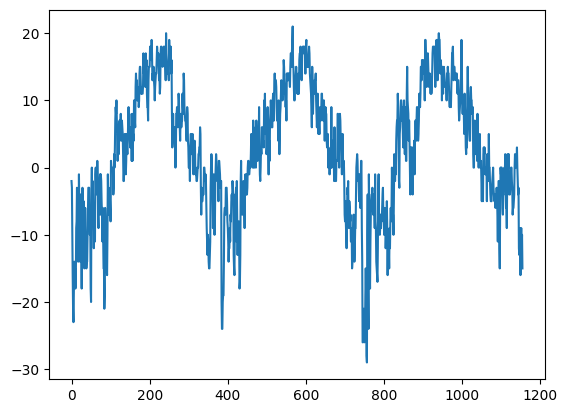

In [175]:
plt.plot(train.index, train.values)

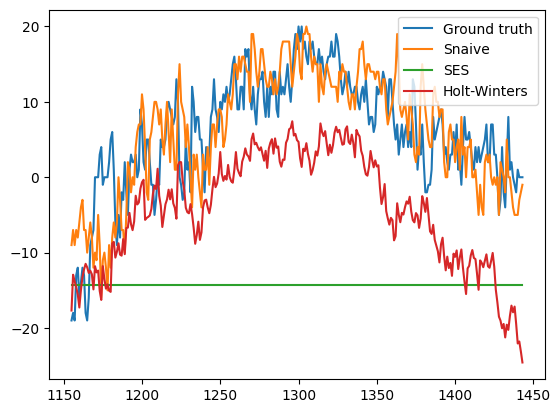

In [176]:
plt.plot(test.index, test.values, label="Ground truth")
plt.plot(test.index, forecasts["snaive"], label="Snaive")
plt.plot(test.index, forecasts["SES"], label="SES")
plt.plot(test.index, forecasts["Holt-Winters"], label="Holt-Winters")
plt.legend()

In [183]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.max([np.full(len(y_true), 1e-6), np.abs(y_true)])))
    
    return {
        'Модель': model_name,
        'MSE': round(mse, 6),
        'RMSE': round(rmse, 6),
        'MAE': round(mae, 6),
        'MAPE': round(mape, 6)
    }

In [185]:
results = []
for model_name, forecast in forecasts.items():
    results.append(calculate_metrics(test.values, forecast.values, model_name))

results_df = pd.DataFrame(results)
results_df

,Модель,MSE,RMSE,MAE,MAPE
0,snaive,34.231834,5.850798,4.591696,0.229585
1,Holt-Winters,140.611701,11.857980,10.605499,0.530275
2,SES,466.881322,21.607437,20.388593,1.019430


Наилучший результат показал snaive, что можно объяснить отсутствием какого-либо общего тренда на изменение температуры и наличием сильной годовой сезонности данных. Также можно выделить малого объема данных, из-за чего другие модели могли недообучиться в силу более сложной архитерктуры.